# Classification – Assignment 4

The exercises on this sheet are graded by a maximum of 10 points. You will be asked to implement several functions.

Team work is not allowed. Everybody implements his/her own code. Discussing issues with others is fine, sharing code with others is not. 

If you use any code fragments found on the Internet, make sure you reference them properly.

Except for Ex. 2 (LDA), we will start using [Scikit-learn](http://scikit-learn.org/stable/), a package that implements most of the machine-learning algorithms we have been using. It is quite usefull to learn how to use it but most importantly we should understand what exactly is the algorithm is doing.

Your functions should work when called by the provided test code (functions prefixed with `test` ) which must not be modified. When run, they should produce a plausible output, no warnings, and no unnecessary output. The functions that you write take images as arguments, not image filenames (i.e. do not use imread inside the functions). Your functions should not generate figures/plots themselves, the plots are generated by the test functions.


This exercise focuses on using classification methods, as
implementing most classifiers takes more time than is reasonable in the scope of
this assignment. The exception is the exercise about LDA, which is
simple enough to be done manually. The rest of the programming exercises are very
short.

As in the regression assignment, $Y$ stands for a column vector of "_target_" values, that is the $i$-th row of $Y$ contains the desired output for the $i$-th
data point. Contrary to regression, the elements of $Y$ are integer values. In
most exercises we use binary classifiers, where one class has the label $1$ and
the other class has the label $2$. 
$X$ is a matrix containing the feature values, where the $i$-th row contains
the values for the $i$-th data point.

The synthetic data are generated randomly for each run in the
"_toy example_" test functions, so you can run the functions multiple times to get
different outputs.

In your answers, comment on the performance of the individual
methods when applied on the aerial photo of Graz. Describe also the difference
between the results on data seen during training (the upper quarter of the image) and
data that are "_new_" (the rest of the image). Does a given method work equally
well for every class?}
You can (and actually need to in order to give a full answer)
change the "_true_" class in the test functions that use binary
classification by changing the __true_class__ variable if you want to see
outputs for different classes.

Hint: To create slices of training data depending on the label value you can use something like this:`X_1 = X[Y == 1, :]`

In [46]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import cv2

%matplotlib inline

## Exercise 1 --- Nearest Neighbours (1 Points)

Nearest neighbour classification (especially its k-NN variant) is a simple
but yet quite powerful classification method which does not make any 
assumptions about the data model.

Using the function [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) k-NN classification is demonstrated
in using 2 different datasets:

### 1.1. Toy Dataset

Implemented in `demo_knn_toy`. Classes:
- 1: blue
- 2 : red

In [29]:
## DO NOT MODIFY HERE ###########################################################
def synthetic_nonlin():
    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        
        return x, y

    n_samples = 100
    X_1 = np.random.randn(n_samples, 2) / 2
    
    a, b = pol2cart(np.random.rand(n_samples, 1) * 2 * np.pi, np.random.randn(n_samples, 1) / 3 + 1.5)
    X_2 = np.hstack([a, b])
    X = np.concatenate([X_1, X_2], axis=0)
    Y = np.concatenate([np.ones((n_samples)), 2 * np.ones((n_samples))]) - 1
    
    return X, Y

def decision_boundaries_vec(x_range, steps, classifier):
    l = np.linspace(x_range[0], x_range[1], steps)
    x, y = np.meshgrid(l, l)
    
    features = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=-1)
    
    if hasattr(classifier, 'predict'):
        return x, y, classifier.predict(features).reshape(x.shape)
    else:
        return x, y, classifier(features).reshape(x.shape)
#############################################################

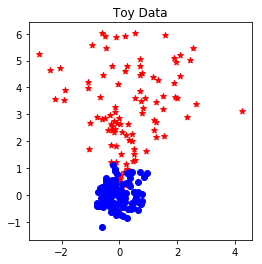

In [30]:
def plot_toy():
    X, Y = synthetic_nonlin()

    plt.figure(figsize=(4, 4))
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c='r', marker='*')
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c='b', marker='o')
    plt.title('Toy Data')

plot_toy()

In [44]:
def demo_knn():
    X, Y = synthetic_nonlin()
    k_neighbors = 10
    classifier = KNeighborsClassifier(n_neighbors=k_neighbors)
    classifier.fit(X, Y)

    x_range = np.array([X.min(), X.max()])

    x, y, decision_boundaries = decision_boundaries_vec(x_range, 1000, classifier)
    
    print(X.shape,'\n', Y.shape, '\n', decision_boundaries.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(x, y, decision_boundaries)
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c='r', marker='*')
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c='b', marker='o')
    plt.title(f'KNN (K={k_neighbors})')

Run the demo functions for different values of parameter $K$,
$distance$ and $rule$ and comment the
results in your report. Also report the best parameters with explanation
why you think that they are the best. Please provide a metric error to support your answer.

(200, 2) 
 (200,) 
 (1000, 1000)


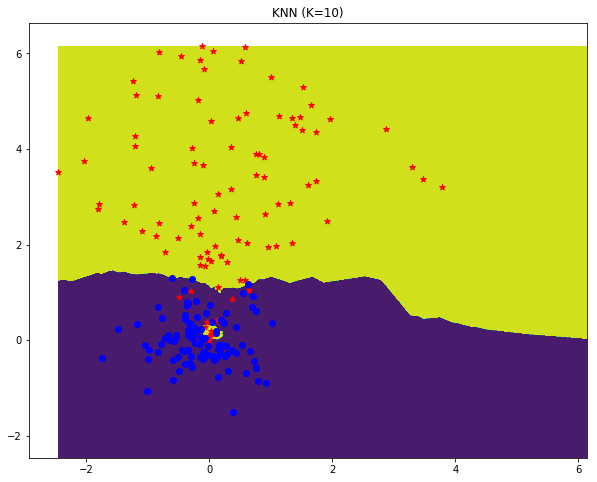

In [45]:
demo_knn()

### 1.2. Graz aerial photo
implemented in `demo_knn_image`.
 Classes:
<div>
<img src="data/graz_5.tif" width="270"/>
</div>

- 1: streets
- 2: buildings
- 3: vegetation

In [42]:
## DO NOT MODIFY HERE ###########################################################
def load_graz(scale):
    img = cv2.imread('data/graz_5.tif')
    gt = cv2.imread('data/gt_graz_5.tif', 0)
    gt[gt == 4] = 3
    new_scale = tuple((np.array(img.shape) * scale).astype(np.int64))[:-1]

    return cv2.resize(img, new_scale), cv2.resize(gt, new_scale)


def create_features(varargin):
    sy, sx, nc = varargin.shape
    return varargin.reshape(sy * sx, nc)
#############################################################

In [43]:
def demo_knn_image():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    # change here to make the classification for different classes (1,2 or 3)
    true_class = 1

    Y = (gt == true_class) + 1

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

    classifier = KNeighborsClassifier(n_neighbors=2)
    classifier.fit(X[:used_train], Y[:used_train])
    # Here we predict over the complete image 
    # including training data, which should not be used if measuring the error.
    results = classifier.predict(X).reshape(sy,sx)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title("Results")
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title("Original")

In [ ]:
demo_knn_image()

Run the functions for different values of parameter $K$, $distance$ and $rule$ and comment the
results in your report. Also report the best parameters with explanation
why you think that they are the best. Same as before, you may want to measure the error to support your analysis.

## Exercise 2 --- LDA (4 Points)

LDA classifier can be used to efficiently classify linearly separable data.
Implement function `ii_train_lda` that trains an LDA classifier. The
input arguments are the training data (one row per sample and one column per
feature) and a column vector with the class labels of the samples (0
or 1). Return the normal $\theta$ of the decision boundary and the threshold
$t$ between classes (so that if $X\theta - t > 0$, class $1$ is predicted).
Since we use row vectors as features, the formulas are slightly different
from those seen in the lecture (but $\theta$ is still a column vector).

$m_1$ and $m_2$ are the means of the input features over all rows
where $Y$ is $0$ or $1$ respectively. You can calculate mean and covariance
for the classes with corresponding __numpy__ methods.
In order to do operations on the rows of $X$ where the corresponding row in $Y$
has a certain value (e.g.\ $1$), you can use the expression `X[Y==1,:]`.
Instead of determining $\theta$ by matrix inversion, which is numerically
unstable, use __numpy/scipy__ equation solving capabilities:


`normal = np.linalg.lstsq(SW, (m2-m1).T)[0]`


where SW is the sum of within-class covariances.
The threshold you output is the value of the projection at the point located
in the middle between the class means (the (dot) product of the mean of
$m_1$ and $m_2$ and the estimated normal).

The corresponding `test_lda` is already provided. You can use
functions `test_lda` and `test_lda2` to test your implementation and generate
results for the report.

In [53]:
def ii_train_lda(X,Y):
    '''
    Parameters
    ----------
    X: input matrix of size Nxd, where d is the number of features and N the number of samples
    Y: label vector of size N. int values 0 or 1.
    
    Returns
    -------
    normal: vector of size d
    t: boundary in projected space
    '''
    
    X_zero = X[Y==0,:]
    X_one = X [Y==1,:]
    
    mean_zero = np.mean(X_zero, axis = 0)
    mean_one = np.mean(X_one, axis = 0)
    cov_zero = np.cov(X_zero.T)
    cov_one = np.cov(X_one.T)
    
    SW = cov_zero + cov_one
    normal = np.linalg.lstsq(SW, (mean_one-mean_zero).T)[0]
    t = 
    
    return normal, t

def ii_test_lda(X, normal, threshold):
    '''
    Parameters
    ----------
    X: input matrix of size Nxd, where d is the number of features and N the number of samples
    normal: vector of size d
    t: boundary in projected space
    
    Returns
    -------
    y_pred: Nx1 predicted class
    '''
    
    
    return y_pred

In [58]:
ss = np.array([[0,1],[1,2],[2,3]])
print(np.mean(ss,axis = 0), '\n', np.cov(ss.T))

[1. 2.] 
 [[1. 1.]
 [1. 1.]]


In [61]:
X, Y = synthetic_nonlin()
X_zero = X[Y==0,:]
X_one = X [Y==1,:]
    
mean_zero = np.mean(X_zero, axis = 0)
mean_one = np.mean(X_one, axis = 0)
cov_zero = np.cov(X_zero.T)
cov_one = np.cov(X_one.T)

SW = cov_zero + cov_one
normal = np.linalg.lstsq(SW, (mean_one-mean_zero).T)[0]


print(X.shape, Y.shape ,'\n',X_zero.shape, mean_zero.shape, cov_zero.shape, '\n', normal.shape)

(200, 2) (200,) 
 (100, 2) (2,) (2, 2) 
 (2,)


C:\Users\Ketzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


In [50]:
## DO NOT MODIFY HERE ###########################################################
def rotate_base(mat, ang):
    R = np.array([
        [np.cos(ang), np.sin(ang)],
        [-np.sin(ang), np.cos(ang)]
    ])
    
    return R.T.dot(mat).dot(R)

def mvarnormal(numelements, Sigma, mu):
    R = np.linalg.cholesky(Sigma)
    data = np.tile(mu, (numelements, 1))
    data = data + np.random.randn(numelements, len(mu)).dot(R)
    return data


def two_gaussians(samples_per_gaussian, m1, m2, S1, S2):
    Y = np.ones((samples_per_gaussian * 2))
    Y[-samples_per_gaussian:] = 0
    X = np.concatenate([mvarnormal(samples_per_gaussian, S1, m1), mvarnormal(samples_per_gaussian, S2, m2)])
    
    return X, Y


def synthetic_lin():
    S = np.array([[10, 0],
                  [0, 5]])
    X, Y = two_gaussians(50, [-4, 0], [4, 0], rotate_base(S, np.pi / 4), rotate_base(S, np.pi / 3))
    return X, Y

################################################################################

In [ ]:
from itertools import combinations as comb

def del_first_col(x):
    return x[:, 1:].copy()

def x2fx(x, model='linear'):
    linear = np.c_[np.ones(x.shape[0]), x]
    if model == 'linear':
        return linear
    if model == 'purequadratic':
        return np.c_[linear, x**2]
    interaction = np.hstack([x[:,i]*x[:,j] for i, j in
                                 comb(range(x.shape[1]), 2)]).T
    if model == 'interaction':
        return np.c_[linear, interaction]
    if model == 'quadratic':
        return np.c_[linear, interaction, x**2]

def test_lda():
    x_range = [-10, 10]

    X, Y = synthetic_lin()

    normal, threshold = ii_train_lda(X, Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_lda(x, normal, threshold)
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('LDA')

    x_range = [-5, 5]
    X, Y = synthetic_nonlin()

    normal, threshold = ii_train_lda(del_first_col(x2fx(X, 'quadratic')), Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_lda(del_first_col(x2fx(x, 'quadratic')), normal, threshold)
    )
    
    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('LDA (lifted)')


def test_lda2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 3

    Y = gt == true_class

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

    normal, threshold = ii_train_lda(X[:used_train, :], Y[:used_train])

    results = ii_test_lda(X, normal, threshold)

    results = results.reshape(sy, sx)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

## Exercise 3 --- Logistic Regression (2 Points)

Logistic regression is a probabilistically principled classification method.
You are provided with the breast cancer dataset. You task is to implement function `ii_train_logress`
that uses __sciki-learn__ class `sklearn.linear_model.LogisticRegression` to fit a logistic regression model to the data. It should take
the same input arguments as train_lda and return the trained model. Also implement function `ii_test_logress`
that takes the trained model and input
features (in the common format) and returns the output of the logistic
regression model. Make sure you cget through the documentation for [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

You can use functions `test_logress` and `test_logress2` to test your
implementation.

Implement the function `classify_breast_cancer_with_logress` which using the functions `ii_train_logress` and
`ii_test_logress` can distinguish benign and malignant tumor. Use 75% of the dataset for training.

Note, that there are missing values in the dataset. You have to either:
* remove such examples
* interpolate missing values

in order to let python load the data for you with `pandas.read_csv('data/data.csv')`.

You can find description of the dataset in file _description.txt_.
Report how well logistic regression works for the breast cancer prediction (accuracy).

In [ ]:
def ii_train_logress(X,Y):
    '''
    
    Parameters
    ----------
    X: input matrix of size Nxd, where d is the number of features and N the number of samples
    Y: label vector of size N. int values 0 or 1.
    
    
    Returns
    -------
    model: trained model of class sklearn.linear_model.©
    '''
    
    
    return model

def ii_test_logress(model, X):
    '''
    
    Parameters
    ----------
    model: trained model of class sklearn.linear_model.
    X: input matrix of size Nxd, where d is the number of features and N the number of samples
    
    Returns
    -------
    out: output of the logistic regression model
    '''    
    

    return out

In [ ]:
def test_logres():
    x_range = [-10, 10]
    X, Y = synthetic_lin()
    Y = Y * 2 - 1

    model = ii_train_logress(X, Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: (ii_test_logress(model, x) > 0.5) * 2 - 1
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('Logistic Regression') 

    x_range = [-2.5, 2.5]

    X, Y = synthetic_nonlin()
    Y = Y * 2 - 1

    model = ii_train_logress(del_first_col(x2fx(X,'quadratic')), Y)

    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000,
        lambda x: 1 + (0.5 < ii_test_logress(model, del_first_col(x2fx(x, 'quadratic'))))
    )

    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('Logistic Regression (lifted)') 


def test_logres2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 1

    Y = (gt==true_class) * 2 - 1

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx, 1)

    model  = ii_train_logress(X[:used_train, :], Y[:used_train, :])
    results = ii_test_logress(model, X)
    results = results.reshape(sy, sx) > 0.5

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

## Exercise 4 --- DecisionTree Classification (1 Points)

Classification using random trees and forests is currently very popular
thanks to its efficiency and flexibility.
Implement function `ii_train_tree` that uses sklearn to train a decision tree. The function should use the same
input arguments as the previous training functions, but note that the tree
classifier can handle more than two classes, so this time the input is not
constrained to -1 or 1 (you do not need to handle this, this is done
automatically by the classifier). The function returns the trained decision
tree. Also implement function `ii_test_tree` that takes the trained
decision tree and input features (in the common format) and returns the
prediction made by the tree (search the documentation of sklearn for details.

You can use functions `test_tree` and `test_tree2` to test your
implementation and generate results for the report.

Implement the function `classify_breast_cancer_with_tree` which using the functions `ii_train_tree` and
`ii_test_tree` can distinguish benign and malignant tumor. Use 75% of the dataset for training.


Note: for visualizing the trained classifier you need to run `conda install pydotplus python-graphviz`

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def ii_train_tree(X,Y):
    '''
    
    Parameters
    ----------
    X: input matrix of size Nxd, where d is the number of features and N the number of samples
    Y: label vector of size N. int values 0 or 1.
    
    
    Returns
    -------
    model: trained random forest class
    
    '''
    model = 
    
    return model

def ii_test_tree(model, X):
    '''
    
    Parameters
    ----------
    model: trained random forest class

    X: input matrix of size Nxd, where d is the number of features and N the number of samples
    
    Returns
    -------
    out: output of the logistic regression model
    '''    
    out =  

    return out

In [ ]:
def test_tree():
    x_range = [-10, 10]

    X, Y = synthetic_lin()
    Y = Y * 2 - 1

    model = ii_train_tree(X, Y)
    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_tree(model, x)
    )

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].contourf(x, y, decision_boundaries)
    axs[0].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[0].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[0].set_title('Tree') 

    x_range = [-2.5, 2.5]
    X, Y = synthetic_nonlin()
    Y = Y * 2 - 1

    model = ii_train_tree(X,Y)
    x, y, decision_boundaries = decision_boundaries_vec(
        x_range, 1000, lambda x: ii_test_tree(model, x)
    )

    axs[1].contourf(x, y, decision_boundaries)
    axs[1].scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', marker='*')
    axs[1].scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', marker='o')
    axs[1].set_title('Tree')

    from sklearn.externals.six import StringIO  
    from IPython.display import Image  
    from sklearn.tree import export_graphviz
    import pydotplus
    
    dot_data = StringIO()
    if hasattr(model, 'tree_'):
        export_graphviz(model, out_file=dot_data,  
                        filled=True, rounded=True,
                        special_characters=True)
        graph = [pydotplus.graph_from_dot_data(dot_data.getvalue())]
    else:
        i_tree = 0
        for tree_in_forest in model.estimators_:
            if (i_tree <3):        
                export_graphviz(tree_in_forest, out_file=dot_data)
                graph = pydotplus.graph_from_dot_data(dot_data.getvalue())        
            i_tree = i_tree + 1
    return [g.create_png() for g in graph]


def test_tree2():
    img, gt = load_graz(0.5)

    sy, sx, nc = img.shape

    X = create_features(img)

    train_columns = sx // 4

    true_class = 1

    Y = gt

    used_train = train_columns * sy

    Y = Y.reshape(sy * sx)

    tree = ii_train_tree(X[:used_train, :], Y[:used_train])

    results = ii_test_tree(tree, X)

    results = results.reshape(sy, sx)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].imshow(results, cmap=plt.cm.gray)
    axs[0].set_title('Results')
    axs[1].imshow(Y.reshape(sy, sx), cmap=plt.cm.gray)
    axs[1].set_title('Original')

In [ ]:
from IPython.display import Image
png_list = test_tree()

In [ ]:
Image(png_list[1])

## Exercise 5 --- Cross Validation (2 Points)


Cross validation is a method to evaluate models. A few common method used for cross validations are:

* **Holdout method**: The holdout method is the simplest kind of cross validation. The data set is separated into two sets, called the training set and the testing set. The model is trained on the training set data only. Then the trained model is used to predict the output values for the data in the testing set (it has never seen these output values before). The errors it makes are accumulated to give test set error, which is used to evaluate the model. We used this method in Exercise 4. 



* **K-fold Cross Validation**: is one way to improve over the holdout method. The data set is divided into k subsets, and the holdout method is repeated k times. Each time, one of the k subsets is used as the test set and the other k-1 subsets are put together to form a training set. Then the average error across all k trials is computed. The advantage of this method is that it matters less how the data gets divided. Every data point gets to be in a test set exactly once, and gets to be in a training set k-1 times. The disadvantage of this method is that the training algorithm has to be rerun from scratch k times, which means it takes k times as much computation to make an evaluation.


* **Leave one out cross validation (LOOCV)**: is K-fold cross validation taken to its logical extreme, with K equal to N, the number of data points in the set. That means that N separate times, the function approximator is trained on all the data except for one point and a prediction is made for that point. As before the average error is computed and used to evaluate the model. The disadvantage of this method is that it is computationally very expensive to compute. 


* **Stratified K-fold Cross Validation**: Stratification is the process of rearranging the data so as to ensure that each fold is a good representative of the whole. For example, in a binary classification problem where each class comprises of 50% of the data, it is best to arrange the data such that in every fold, each class comprises of about half the instances.


We will use the dataset from `Exercise 4`. Make sure to load the csv file without header. 

In [ ]:
import pandas as pd
import math

In [ ]:
#read the data.csv file and load it in a dataframe
df = 

#show top 5 rows
df.head()

#check if any missing values


(i) Implement function `k_fold` to divide the dataset into k folds

In [ ]:
def k_fold(dataset, k):
    # dataset containing the samples
    # k is number of folds
    # return the generated folds
    
        
    return folds

(ii) Now run `k_fold()` for K=3 and K=5. Then define training and test sets by combining different folds and run the `classify_breast_cancer_with_tree` and report the performance.

In [ ]:
## Answer here

(iii) Complete the function `LOOCV()` below

In [ ]:
def LOOCV(dataset):
    # dataset containing the samples
    
    #As to do this on the whole dataset would be time consuming and expensive 
    #we will use only a small part of the dataset
    
    #take first 20 rows of the dataset
    d = 
    
    #remove the label column
    X = 
    Y = 
    
    #list for saving predictions
    
    
    #loop over all the dataset with all but one is training
    for i in range(len(d)):
        
        #use classify_breast_cancer_with_tree() to get prediction
        pred = 
        
        #add the prediction to the list
        
    #performance evaluation

(iv) Implement function `k_fold_strat` to divide the dataset into k stratified folds

In [ ]:
def k_fold_strat(dataset, k):
    # dataset containing the samples
    # k is number of folds
    # return the generated folds

    # split dataframe into two dataframes.
    # One containing rows with class 2 and
    # another with class 4
    

    # count number of rows in both dataframes

    # calculate samples per fold for both class

    #loop over k to divide the dataframes
    for i in range(k):

    return folds

(v) Now run `k_fold_strat()` for K=3 and K=5. Then define training and test sets by combining different folds and run the `classify_breast_cancer_with_tree` and report the performance.

In [ ]:
##Answer here